In [1]:
import pandas as pd
import requests
from datetime import datetime, date
import time

class Client:
    def __init__(self):
        self.exchange = "BINANCE"
        
        self._base_url = "https://api.binance.com"
    
    def make_request(self, endpoint, params1: dict()):              
        
        response = requests.get(self._base_url + endpoint, params = params1)      #https://requests.readthedocs.io/en/latest/user/quickstart/#make-a-request
        
        return response.json()
    
    def get_symbols(self) -> list[str]:        #for -> explan. see(https://medium.com/@thomas_k_r/whats-this-weird-arrow-notation-in-python-53d9e293113)
        
        params = dict()
        
        endpoint = "/api/v3/exchangeInfo"
        
        data = self.make_request(endpoint, params)
        
        symbols = [x["symbol"] for x in data["symbols"]]
        
        return symbols
    
    def get_historical_data(self, symbol, start_time, end_time, limit = 1000, interval='2h'):     #the max limit is 1000
        
        params = dict()
        
        params["symbol"] = symbol
        params["interval"] = interval
        params["limit"] = limit
        params["startTime"] = start_time
        params["endTime"] = end_time
        
        endpoint = "/api/v3/klines"
        raw_candles = self.make_request(endpoint, params)
        
        candles = []
        
        for c in raw_candles:
            candles.append((float(c[0]), float(c[1]), float(c[2]), float(c[3]), float(c[4]), float(c[5]),))    #this iterates through columns (above you get data in raw form)
            
        return candles     

    
def ms_to_dt_local(ms) -> datetime:           #https://stackoverflow.com/questions/30921399/datetime-fromtimestamp-vs-datetime-utcfromtimestamp-which-one-is-safer-to-use
    return datetime.fromtimestamp(ms / 1000)

def GetDataFrame(data):
    df = pd.DataFrame(data, columns=['Timestamp', "Open", "High", "Low", "Close", "Volume"])
    df["Timestamp"] = df["Timestamp"].apply(lambda x: ms_to_dt_local(x))     #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
    df["Date"] = df["Timestamp"].dt.strftime("%d/%m/%Y")
    df["Time"] = df["Timestamp"].dt.strftime("%H:%M:%S")
    column_names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
    df = df.set_index("Timestamp")
    df = df.reindex(columns = column_names)
    return df

def GetHistoricalData(client, symbol, start_time, end_time, limit=1000):
    collection = []
    
    while start_time < end_time:
        data = client.get_historical_data(symbol, start_time, end_time, limit)
        print(client.exchange + " " + " : Collected " + str(len(data)) + " initial data from "+ str(ms_to_dt_local(data[0][0])) +" to " + str(ms_to_dt_local(data[-1][0])))
        start_time = int(data[-1][0] + 1000)
        collection +=data
        time.sleep(1.1)
        
    return collection

client = Client()
symbol = "BTCUSDT"
interval = "2h"
fromDate = int(datetime.strptime('2021-04-26', '%Y-%m-%d').timestamp() * 1000)    #you convert time to unix time. 1000 is multiplied to convert to milisec
#toDate = int(datetime.strptime('2022-07-14', '%Y-%m-%d').timestamp() * 1000)     #fromDate is constant (the day when one 1st bought crypto)
#toDate = int((time.time() - 158400) * 1000)   #it gives CET time zone in unix time
#toDate = int(1657749600) * 1000
#toDate = 1657836000 * 1000
Date_Today = date.today() 
toDate = int(time.mktime(Date_Today.timetuple())) * 1000


data = GetHistoricalData(client, symbol, fromDate, toDate)
df = GetDataFrame(data)
df


BINANCE  : Collected 1000 initial data from 2021-04-26 00:00:00 to 2021-07-18 06:00:00
BINANCE  : Collected 1000 initial data from 2021-07-18 08:00:00 to 2021-10-09 18:00:00
BINANCE  : Collected 1000 initial data from 2021-10-09 20:00:00 to 2022-01-01 01:00:00
BINANCE  : Collected 1000 initial data from 2022-01-01 03:00:00 to 2022-03-25 09:00:00
BINANCE  : Collected 1000 initial data from 2022-03-25 11:00:00 to 2022-06-16 18:00:00
BINANCE  : Collected 1000 initial data from 2022-06-16 20:00:00 to 2022-09-08 02:00:00
BINANCE  : Collected 239 initial data from 2022-09-08 04:00:00 to 2022-09-28 00:00:00


,Date,Time,Open,High,Low,Close,Volume
Timestamp,,,,,,,
2021-04-26 00:00:00,26/04/2021,00:00:00,47598.87,49171.76,47507.31,49066.77,8951.458278
2021-04-26 02:00:00,26/04/2021,02:00:00,49066.76,51983.56,48753.44,51920.39,13118.291269
2021-04-26 04:00:00,26/04/2021,04:00:00,51920.39,52500.00,51698.09,52398.99,8205.145727
2021-04-26 06:00:00,26/04/2021,06:00:00,52398.99,52722.35,52000.00,52535.23,5682.955160
2021-04-26 08:00:00,26/04/2021,08:00:00,52535.23,53080.00,52421.23,52801.37,7299.640069
...,...,...,...,...,...,...,...
2022-09-27 16:00:00,27/09/2022,16:00:00,20194.88,20252.90,19865.00,19887.73,56964.458360
2022-09-27 18:00:00,27/09/2022,18:00:00,19887.78,19954.49,18863.01,18957.20,83502.559370
2022-09-27 20:00:00,27/09/2022,20:00:00,18957.95,19180.00,18816.32,19077.59,60207.467870


In [2]:
import numpy as np

df2 = pd.DataFrame(df, columns = ('Date','Close'))      #I took "Close" price of BTC
df2['Date'] = pd.to_datetime(df2['Date'], format = '%d/%m/%Y')    #you always have to add format
df2.rename(columns = {'Close':'BTC_Price'}, inplace = True)


#money spent for BTC, not including fees
df2['Paid_in_GBP'] = np.NaN    
df2['Paid_in_GBP'].loc['2021-04-26 00:00:00'] = 300
df2['Paid_in_GBP'].loc['2021-06-01 20:00:00'] = 300
df2['Paid_in_GBP'].loc['2022-01-01 21:00:00'] = 300
df2['Paid_in_GBP'].loc['2022-06-01 20:00:00'] = 300


#conversion to USD based on https://www.xe.com/currencycharts/?from=GBP&to=USD&view=2Y
df2['GBP_to_USD_Paid'] = np.NaN
df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00'] = 300 * 1.38676     #conversion rate on 26.04.21
df2['GBP_to_USD_Paid'].loc['2021-06-01 20:00:00'] = 300 * 1.42267   
df2['GBP_to_USD_Paid'].loc['2022-01-01 21:00:00'] = 300 * 1.35289
df2['GBP_to_USD_Paid'].loc['2022-06-01 20:00:00'] = 300 * 1.26073
df2['GBP_to_USD_Paid'] = df2['GBP_to_USD_Paid'].round(2)


#BTC that was owned
df2['BTC_Own'] = np.NaN
df2['BTC_Own'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'] = df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00'] / df2['BTC_Price'].loc['2021-04-26 00:00:00']
df2['BTC_Own'].loc['2021-06-01 20:00:00':'2022-01-01 20:00:00'] = (df2['GBP_to_USD_Paid'].loc['2021-06-01 20:00:00'] / df2['BTC_Price'].loc['2021-06-01 20:00:00']) + (df2['BTC_Own'].loc['2021-04-26 00:00:00'])
df2['BTC_Own'].loc['2022-01-01 21:00:00':'2022-06-01 20:00:00'] = (df2['GBP_to_USD_Paid'].loc['2022-01-01 21:00:00'] / df2['BTC_Price'].loc['2022-01-01 21:00:00']) + (df2['BTC_Own'].loc['2022-01-01 19:00:00']) 
df2['BTC_Own'].loc['2022-06-01 20:00:00':df.index[-1]] = df2['GBP_to_USD_Paid'].loc['2022-06-01 20:00:00'] / df2['BTC_Price'].loc['2022-06-01 20:00:00'] + (df2['BTC_Own'].loc['2022-06-01 20:00:00'])


#fees from buying BTC on a crypto exchange
df2['Fees_in_GBP'] = np.NaN
df2['Fees_in_GBP'].loc['2021-04-26 00:00:00'] = 5
df2['Fees_in_GBP'].loc['2021-06-01 20:00:00'] = 5
df2['Fees_in_GBP'].loc['2022-01-01 21:00:00'] = 5
df2['Fees_in_GBP'].loc['2022-06-01 20:00:00'] = 5


#conversion of fees to USD
df2['GBP_to_USD_Fees'] = np.NaN
df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00'] = 5 * 1.38676 
df2['GBP_to_USD_Fees'].loc['2021-06-01 20:00:00'] = 5 * 1.42267
df2['GBP_to_USD_Fees'].loc['2022-01-01 21:00:00'] = 5 * 1.35289
df2['GBP_to_USD_Fees'].loc['2022-06-01 20:00:00'] = 5 * 1.26073
df2['GBP_to_USD_Fees'] = df2['GBP_to_USD_Fees'].round(2)


#actual money (USD) owned at different time periods
df2['USD_Owned'] = np.NaN
df2['USD_Owned'] = df2['BTC_Own'].multiply(df2['BTC_Price'])
df2['USD_Owned'] = df2['USD_Owned'].round(2)


#profit or loss of the investment 
df2['Gain_Loss_in_USD'] = np.NaN
df2['Gain_Loss_in_USD'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'] = df2['USD_Owned'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'] - (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'].sum())
df2['Gain_Loss_in_USD'].loc['2021-06-01 20:00:00':'2022-01-01 19:00:00'] = df2['USD_Owned'].loc['2021-06-01 20:00:00':'2022-01-01 19:00:00'] - (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':'2022-01-01 19:00:00'].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':'2022-01-01 19:00:00'].sum())
df2['Gain_Loss_in_USD'].loc['2022-01-01 20:00:00':'2022-06-01 19:00:00'] = df2['USD_Owned'].loc['2022-01-01 20:00:00':'2022-06-01 19:00:00'] - (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':'2022-06-01 19:00:00'].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':'2022-06-01 19:00:00'].sum())
df2['Gain_Loss_in_USD'].loc['2022-06-01 20:00:00':df.index[-1]] = df2['USD_Owned'].loc['2022-06-01 20:00:00':df.index[-1]] - (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':df.index[-1]].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':df.index[-1]].sum())


#percentage of loss/profit compared to the investment
df2['Gain_Loss_Pct.'] = np.NaN
df2['GBP_to_USD_Paid'] = df2['GBP_to_USD_Paid'].fillna(0)
df2['GBP_to_USD_Fees'] = df2['GBP_to_USD_Fees'].fillna(0)
df2['Gain_Loss_Pct.'] = df2['USD_Owned'] / (df2['GBP_to_USD_Paid'].cumsum() + df2['GBP_to_USD_Fees'].cumsum())


#the percentage change between values in a column every 2 hours
df2['Pct. Change (Gain/Loss_2h)'] = df2['Gain_Loss_in_USD'].pct_change() 
df2['Pct. Change (Gain/Loss_2h)'] = df2['Pct. Change (Gain/Loss_2h)'].round(4)


#change between values in a column in USD
df2['USD Change (Gain/Loss_2h)'] = df2['Pct. Change (Gain/Loss_2h)']
df2['USD Change (Gain/Loss_2h)'] = df2['USD Change (Gain/Loss_2h)'].shift(periods=-1, axis='index')
df2['USD Change (Gain/Loss_2h)'] = df2['Gain_Loss_in_USD'].multiply(df2['USD Change (Gain/Loss_2h)'])
df2['USD Change (Gain/Loss_2h)'] = df2['USD Change (Gain/Loss_2h)'].shift(periods=1, axis='index')
df2['USD Change (Gain/Loss_2h)'] = df2['USD Change (Gain/Loss_2h)'].round(2)


#BTC price that you need to be even with your investment
df2['BTC_Price_Even'] = np.NaN
df2['BTC_Price_Even'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'] = (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00'].sum()) / df2['BTC_Own'].loc['2021-04-26 00:00:00':'2021-06-01 19:00:00']
df2['BTC_Price_Even'].loc['2021-06-01 20:00:00':'2022-01-01 19:00:00'] = (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':'2022-01-01 19:00:00'].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':'2022-01-01 19:00:00'].sum()) / df2['BTC_Own'].loc['2021-06-01 20:00:00':'2022-01-01 19:00:00']
df2['BTC_Price_Even'].loc['2022-01-01 20:00:00':'2022-06-01 19:00:00'] = (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':'2022-06-01 19:00:00'].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':'2022-06-01 19:00:00'].sum()) / df2['BTC_Own'].loc['2022-01-01 20:00:00':'2022-06-01 19:00:00']
df2['BTC_Price_Even'].loc['2022-06-01 20:00:00':df.index[-1]] = (df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':df.index[-1]].sum() + df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':df.index[-1]].sum()) / df2['BTC_Own'].loc['2022-06-01 20:00:00':df.index[-1]]


#cumulative return of BTC       https://www.investopedia.com/terms/c/cumulativereturn.asp
df2['Cum_Ret_BTC'] = np.NaN                
df2['Cum_Ret_BTC'] = ((df2['BTC_Price'].pct_change()) + 1).cumprod() - 1 


#df2.head(15)      #to display 15 rows
df2.loc['2021-04-26 00:00:00':df.index[-1]]
#df2.loc['2021-01-01 17:00:00':'2022-06-01 23:00:00']

/var/folders/yd/4bqr74756w373nwgx55rfshh0000gn/T/ipykernel_950/3665319817.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Paid_in_GBP'].loc['2021-04-26 00:00:00'] = 300
/var/folders/yd/4bqr74756w373nwgx55rfshh0000gn/T/ipykernel_950/3665319817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Paid_in_GBP'].loc['2021-06-01 20:00:00'] = 300
/var/folders/yd/4bqr74756w373nwgx55rfshh0000gn/T/ipykernel_950/3665319817.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,Date,BTC_Price,Paid_in_GBP,GBP_to_USD_Paid,BTC_Own,Fees_in_GBP,GBP_to_USD_Fees,USD_Owned,Gain_Loss_in_USD,Gain_Loss_Pct.,Pct. Change (Gain/Loss_2h),USD Change (Gain/Loss_2h),BTC_Price_Even,Cum_Ret_BTC
Timestamp,,,,,,,,,,,,,,
2021-04-26 00:00:00,2021-04-26,49066.77,300.0,416.03,0.008479,5.0,6.93,416.03,-6.93,0.983615,NaN,NaN,49884.097395,NaN
2021-04-26 02:00:00,2021-04-26,51920.39,NaN,0.00,0.008479,NaN,0.00,440.23,17.27,1.040831,-3.4921,24.20,49884.097395,0.058158
2021-04-26 04:00:00,2021-04-26,52398.99,NaN,0.00,0.008479,NaN,0.00,444.28,21.32,1.050407,0.2345,4.05,49884.097395,0.067912
2021-04-26 06:00:00,2021-04-26,52535.23,NaN,0.00,0.008479,NaN,0.00,445.44,22.48,1.053149,0.0544,1.16,49884.097395,0.070689
2021-04-26 08:00:00,2021-04-26,52801.37,NaN,0.00,0.008479,NaN,0.00,447.70,24.74,1.058493,0.1005,2.26,49884.097395,0.076113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27 16:00:00,2022-09-27,19887.73,NaN,0.00,0.041475,NaN,0.00,824.83,-829.19,0.498682,0.0156,-12.74,39880.389633,-0.594680
2022-09-27 18:00:00,2022-09-27,18957.20,NaN,0.00,0.041475,NaN,0.00,786.24,-867.78,0.475351,0.0465,-38.56,39880.389633,-0.613645
2022-09-27 20:00:00,2022-09-27,19077.59,NaN,0.00,0.041475,NaN,0.00,791.23,-862.79,0.478368,-0.0058,5.03,39880.389633,-0.611191


In [3]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

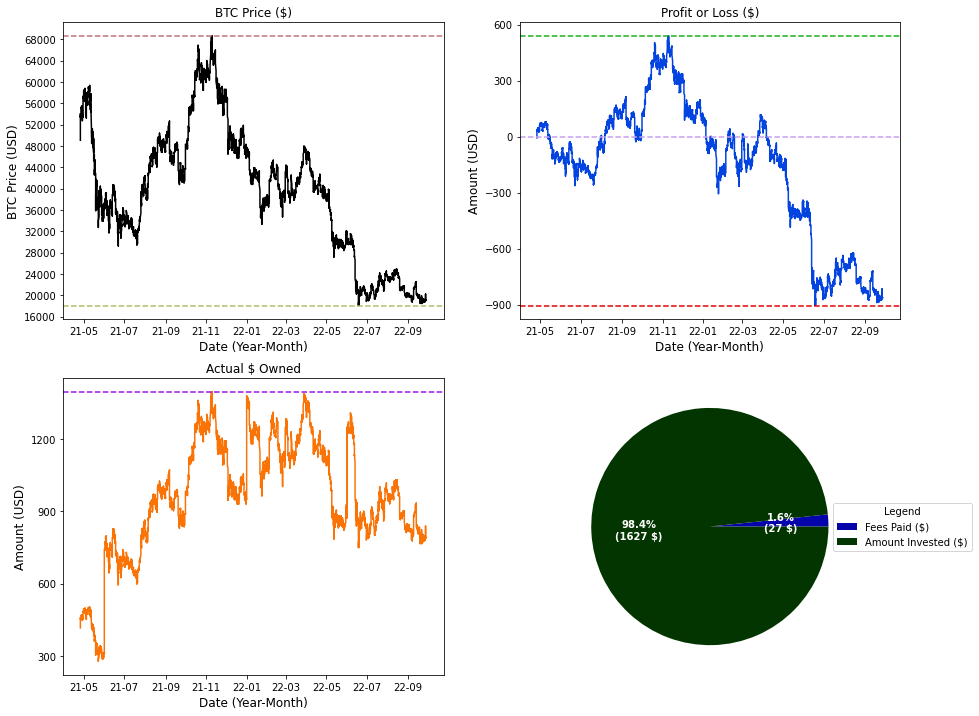

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

date_form = DateFormatter('%y-%m')

ax1.plot(df2['Date'], df2['BTC_Price'], color='xkcd:black')    #https://matplotlib.org/stable/tutorials/colors/colors.html
ax1.set_title('BTC Price ($)')                                 #https://xkcd.com/color/rgb/
ax1.set(xlabel='Date (Year-Month)', ylabel='BTC Price (USD)')
ax1.xaxis.label.set_size(12)
ax1.yaxis.label.set_size(12)
ax1.xaxis.set_major_formatter(date_form)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(4000))
t = df2['BTC_Price'].max()
t2 = df2['BTC_Price'].min()
ax1.axhline(y=t, color='xkcd:dusty rose', linestyle='--')
ax1.axhline(y=t2, color='xkcd:light olive', linestyle='--')

ax2.plot(df2['Date'], df2['Gain_Loss_in_USD'], color='xkcd:blue')        #you can change here to ax2.scatter to get other types, etc.
ax2.set_title('Profit or Loss ($)')
ax2.set(xlabel='Date (Year-Month)', ylabel='Amount (USD)')
ax2.xaxis.label.set_size(12)
ax2.yaxis.label.set_size(12)
ax2.xaxis.set_major_formatter(date_form)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(300))
m = df2['Gain_Loss_in_USD'].max()
m2 = df2['Gain_Loss_in_USD'].min()
ax2.axhline(y=m, color='xkcd:green', linestyle='--')
ax2.axhline(y=m2, color='xkcd:red', linestyle='--')
ax2.axhline(y=0, color='xkcd:lavender', linestyle='--')


ax3.plot(df2['Date'], df2['USD_Owned'], color='xkcd:orange')
ax3.set_title('Actual $ Owned')
ax3.set(xlabel='Date (Year-Month)', ylabel='Amount (USD)')
ax3.xaxis.label.set_size(12)
ax3.yaxis.label.set_size(12)
ax3.xaxis.set_major_formatter(date_form)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(300))
m1 = df2['USD_Owned'].max()
ax3.axhline(y=m1, color='xkcd:violet', linestyle='--')


sum_fees = df2['GBP_to_USD_Fees'].loc['2021-04-26 00:00:00':df.index[-1]].sum()
sum_paid = df2['GBP_to_USD_Paid'].loc['2021-04-26 00:00:00':df.index[-1]].sum()
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} $)".format(pct, absolute)
wedges, texts, autotexts = ax4.pie([sum_fees, sum_paid], autopct=lambda pct: func(pct, [sum_fees, sum_paid]), 
                                   colors=['xkcd:royal blue','xkcd:dark green'], textprops=dict(color="xkcd:white"))
ax4.legend(wedges, ['Fees Paid ($)', 'Amount Invested ($)'], title="Legend", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")
plt.show()


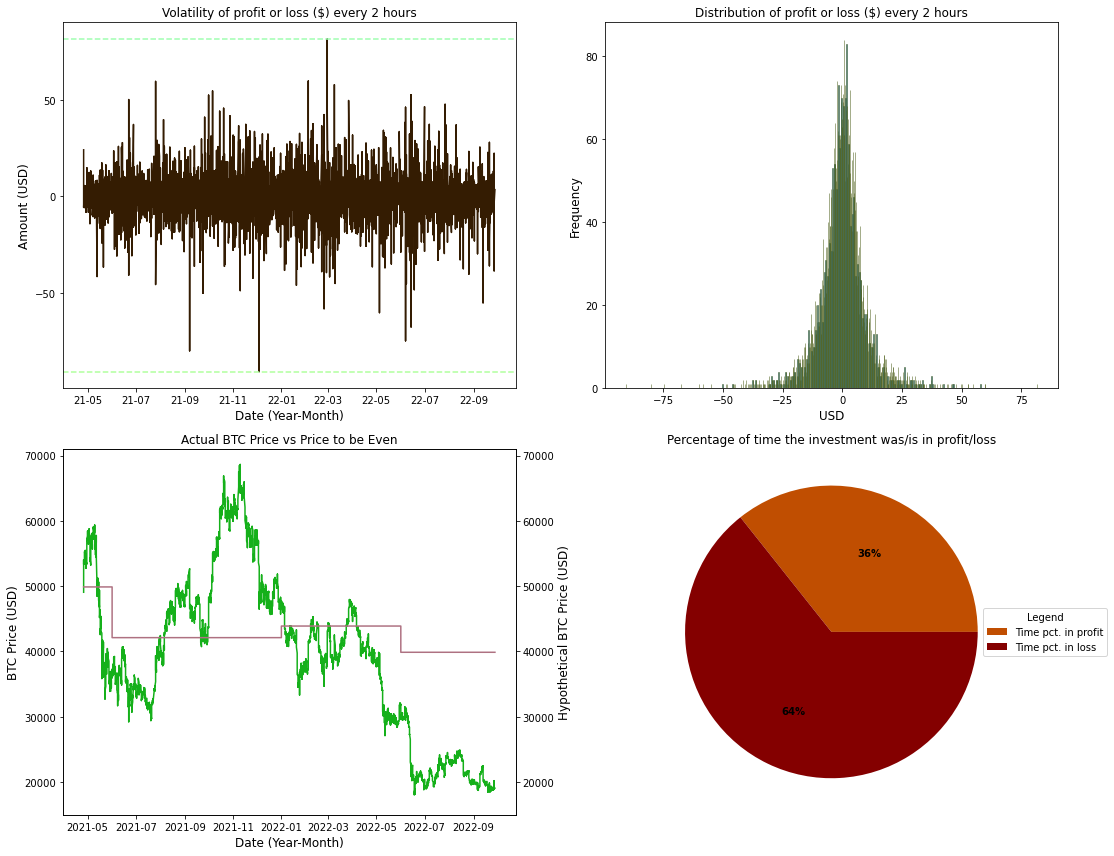

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

date_form = DateFormatter('%y-%m')

#profit or loss in USD over time
ax1.plot(df2['Date'],df2['USD Change (Gain/Loss_2h)'], color='xkcd:dark brown')       
ax1.set_title('Volatility of profit or loss ($) every 2 hours')
ax1.set(xlabel='Date (Year-Month)', ylabel='Amount (USD)')
ax1.xaxis.label.set_size(12)
ax1.yaxis.label.set_size(12)
ax1.xaxis.set_major_formatter(date_form)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))
u = df2['USD Change (Gain/Loss_2h)'].max()
l = df2['USD Change (Gain/Loss_2h)'].min()
ax1.axhline(y=u, color='xkcd:mint', linestyle='--')
ax1.axhline(y=l, color='xkcd:pastel green', linestyle='--')


#histogram of profit or loss in USD over time
ax2.hist(df2['USD Change (Gain/Loss_2h)'], rwidth=0.5, bins=1000, linewidth=0.5, edgecolor='xkcd:army green')  
ax2.set_title('Distribution of profit or loss ($) every 2 hours')
ax2.set(xlabel='USD', ylabel='Frequency')
ax2.xaxis.label.set_size(12)
ax2.yaxis.label.set_size(12)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))


#the price that BTC had to hit at particular time to make the investment even
ax3.plot(df2['Date'], df2['BTC_Price'], color='xkcd:green')
ax3.set_ylim(15000,71000)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(10000))
ax3.set_title('Actual BTC Price vs Price to be Even')
ax3.set_xlabel('Date (Year-Month)')
ax3.set_ylabel('BTC Price (USD)')
ax3.xaxis.label.set_size(12)
ax3.yaxis.label.set_size(12)
ax = ax3.twinx()                              #https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py
ax.plot(df2['Date'], df2['BTC_Price_Even'], color='xkcd:mauve')
ax.set_ylim(15000,71000)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10000))
ax.set_ylabel('Hypothetical BTC Price (USD)')
ax.yaxis.label.set_size(12)
fig.tight_layout()


#the percentage of time in gain vs in loss

gain=[]
loss=[]
even=[]
for v in df2['Gain_Loss_in_USD']:
    if v>0:
        gain.append('a')
    elif v<0:
        loss.append('b')
    elif v==0:
        even.append('c')
    else:
        pass
    
a = len(gain) 
b = len(loss)
c = len(even)
d = a + b + c
g = a/d
l = b/d

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.0f}%".format(pct, absolute)
wedges, texts, autotexts = ax4.pie([g, l], autopct=lambda pct: func(pct, [g, l]), 
                                   colors=['xkcd:burnt orange','xkcd:dark red'], textprops=dict(color="xkcd:black"))
ax4.legend(wedges, ['Time pct. in profit', 'Time pct. in loss'], title="Legend", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")
ax4.set_title('Percentage of time the investment was/is in profit/loss')
plt.show()

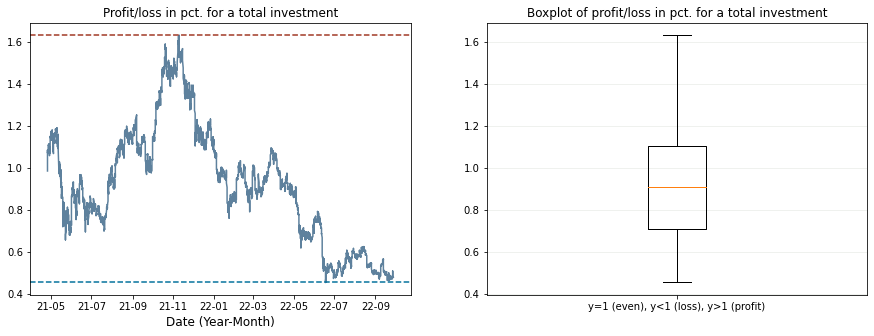

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

date_form = DateFormatter('%y-%m')

ax1.set_title('Profit/loss in pct. for a total investment')
ax1.plot(df2['Date'],df2['Gain_Loss_Pct.'], 'xkcd:greyish blue')
ax1.set(xlabel='Date (Year-Month)')
ax1.xaxis.label.set_size(12)
ax1.yaxis.label.set_size(12)
ax1.xaxis.set_major_formatter(date_form)
p = df2['Gain_Loss_Pct.'].max()
p2 = df2['Gain_Loss_Pct.'].min()
ax1.axhline(y=p, color='xkcd:brick', linestyle='--')
ax1.axhline(y=p2, color='xkcd:ocean blue', linestyle='--')


#https://sixsigmastudyguide.com/box-plots/
ax2.boxplot(df2['Gain_Loss_Pct.'])
ax2.set_title('Boxplot of profit/loss in pct. for a total investment')
ax2.yaxis.grid(True, linestyle='-', which='major', color='xkcd:light grey',
               alpha=0.5)
ax2.set_xticks(ticks=[1], labels=['y=1 (even), y<1 (loss), y>1 (profit)'])
ax2.xaxis.label.set_size(12)


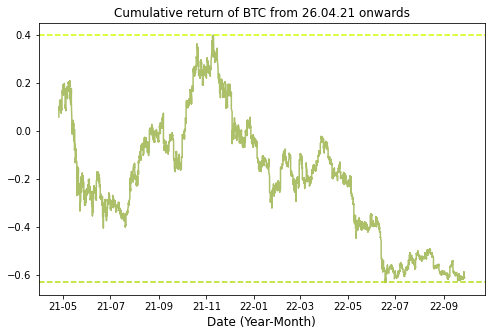

In [10]:
#cum return of BTC from 26.04 onwards
date_form = DateFormatter('%y-%m')

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Cumulative return of BTC from 26.04.21 onwards')
ax.plot(df2['Date'],df2['Cum_Ret_BTC'], 'xkcd:light olive')
ax.set(xlabel='Date (Year-Month)')
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.xaxis.set_major_formatter(date_form)
i = df2['Cum_Ret_BTC'].max()
i2 = df2['Cum_Ret_BTC'].min()
ax.axhline(y=i, color='xkcd:greenish yellow', linestyle='--')
ax.axhline(y=i2, color='xkcd:yellowish green', linestyle='--')

plt.show()

In [11]:
#numerical representation of profit or loss in $
abc=df2.groupby('Gain_Loss_in_USD')

def peak_to_peak(arr):
    return arr.max()

abc.agg(peak_to_peak)


,Date,BTC_Price,Paid_in_GBP,GBP_to_USD_Paid,BTC_Own,Fees_in_GBP,GBP_to_USD_Fees,USD_Owned,Gain_Loss_Pct.,Pct. Change (Gain/Loss_2h),USD Change (Gain/Loss_2h),BTC_Price_Even,Cum_Ret_BTC
Gain_Loss_in_USD,,,,,,,,,,,,,
-904.67,2022-06-18,18067.60,NaN,0.0,0.041475,NaN,0.0,749.35,0.453048,0.0260,-22.92,39880.389633,-0.631775
-902.25,2022-06-19,18126.08,NaN,0.0,0.041475,NaN,0.0,751.77,0.454511,0.0086,-7.69,39880.389633,-0.630583
-894.75,2022-06-19,18306.93,NaN,0.0,0.041475,NaN,0.0,759.27,0.459045,-0.0083,7.49,39880.389633,-0.626898
-894.58,2022-06-19,18311.09,NaN,0.0,0.041475,NaN,0.0,759.44,0.459148,0.0079,-7.01,39880.389633,-0.626813
-888.41,2022-09-19,18459.71,NaN,0.0,0.041475,NaN,0.0,765.61,0.462878,0.0150,-13.13,39880.389633,-0.623784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528.44,2021-11-09,68097.41,NaN,0.0,0.020343,NaN,0.0,1385.31,1.616710,-0.0149,-7.99,42121.078457,0.387852
530.93,2021-11-09,68219.99,NaN,0.0,0.020343,NaN,0.0,1387.80,1.619616,0.0143,7.49,42121.078457,0.390350
533.55,2021-11-10,68348.63,NaN,0.0,0.020343,NaN,0.0,1390.42,1.622673,0.0141,7.42,42121.078457,0.392972


In [12]:
#numerical representation of $ owned
abc=df2.groupby('USD_Owned')

def peak_to_peak(arr):
    return arr.max()

abc.agg(peak_to_peak)

,Date,BTC_Price,Paid_in_GBP,GBP_to_USD_Paid,BTC_Own,Fees_in_GBP,GBP_to_USD_Fees,Gain_Loss_in_USD,Gain_Loss_Pct.,Pct. Change (Gain/Loss_2h),USD Change (Gain/Loss_2h),BTC_Price_Even,Cum_Ret_BTC
USD_Owned,,,,,,,,,,,,,
277.39,2021-05-23,32715.82,NaN,0.0,0.008479,NaN,0.0,-145.57,0.655830,0.0364,-5.11,49884.097395,-0.333239
280.24,2021-05-23,33051.73,NaN,0.0,0.008479,NaN,0.0,-142.72,0.662569,-0.0196,2.85,49884.097395,-0.326393
282.50,2021-05-23,33318.09,NaN,0.0,0.008479,NaN,0.0,-140.46,0.667912,0.0200,-2.75,49884.097395,-0.320964
285.25,2021-05-23,33642.07,NaN,0.0,0.008479,NaN,0.0,-137.71,0.674414,0.1205,-14.81,49884.097395,-0.314361
287.36,2021-05-29,33891.84,NaN,0.0,0.008479,NaN,0.0,-135.60,0.679402,0.0339,-4.45,49884.097395,-0.309271
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386.91,2022-03-28,47956.28,NaN,0.0,0.028920,NaN,0.0,117.41,1.092485,0.0965,10.33,43896.629857,-0.022632
1387.80,2021-11-09,68219.99,NaN,0.0,0.020343,NaN,0.0,530.93,1.619616,0.0143,7.49,42121.078457,0.390350
1390.42,2021-11-10,68348.63,NaN,0.0,0.020343,NaN,0.0,533.55,1.622673,0.0141,7.42,42121.078457,0.392972
